# Assignment 3

In [1]:
#Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

from scipy import stats
import statsmodels.api as sm

### Import Data

In [2]:
#Import Portfolio Data
port_data_complete = pd.read_csv('25_Portfolios_5x5.csv', skiprows = list(range(0,15)), dtype = np.float64, nrows = 1107)
#Convert Date
port_data_complete['Date'] = pd.to_datetime(port_data_complete['Unnamed: 0'], format = '%Y%m.0')
#Set Index to Date and delete old Date column
port_data_complete = port_data_complete.set_index('Date')
port_data_complete = port_data_complete.drop('Unnamed: 0', axis = 1)

#Import FF Factors and convert Date and set index to 'Date'
FF_Factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows = [0,1,2], dtype = np.float64, nrows = 1107)
#Convert Date
FF_Factors['Date'] = pd.to_datetime(FF_Factors['Unnamed: 0'], format = '%Y%m.0')
#Set Index to Date and delete old Date column
FF_Factors = FF_Factors.set_index('Date')
FF_Factors = FF_Factors.drop('Unnamed: 0', axis = 1)

#Add The risk free rate and the FF Factors to the dataset
data = pd.concat([port_data_complete, FF_Factors], axis = 1, join = 'inner')

In [3]:
#Calculate Excess Returns
ex_returns_complete = pd.DataFrame()

for i in data.columns[:-4]:
    ex_returns_complete[i] = data[i] - data['RF']

#Add FF Factors, RF 
for i in data.columns[-4:]:
    ex_returns_complete[i] = data[i]

### Exercise 1.1

In [4]:
#Only Use Data from Jan 1963 - Dec 1993
excess_returns_ex1 = ex_returns_complete.loc['1963-01-01':'1993-12-01']
excess_returns_ex1.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,,,,,
1963-01-01,12.7652,11.1913,9.4412,10.6091,10.8801,7.3764,5.5634,7.3604,7.9976,10.8621,...,6.5978,5.0045,3.8439,3.2086,6.7185,5.4031,4.93,3.06,2.26,0.25
1963-02-01,-3.4769,-3.7230,-1.0956,-1.0411,2.5540,-4.2490,-2.1193,-2.6279,-1.7649,-0.3176,...,-0.2274,-3.4684,-1.8939,-2.2782,-1.4246,-1.3990,-2.38,0.50,2.21,0.23
1963-03-01,4.7501,-1.7032,-0.8160,1.2184,2.3545,-0.3890,0.9503,1.0122,2.7795,1.0822,...,3.1195,3.4913,2.6020,4.3444,4.9245,4.8249,3.08,-2.62,2.10,0.23
1963-04-01,4.5464,1.2484,2.0266,3.1925,2.5432,2.0807,5.0664,0.3428,3.9201,5.7406,...,4.8882,4.5971,3.8944,5.7291,4.0567,8.1929,4.51,-1.31,1.01,0.25
1963-05-01,3.1528,1.4354,2.5284,3.8397,7.6908,1.8525,2.4919,0.6773,4.5994,4.4280,...,3.4481,2.9448,-0.5712,1.5777,1.4624,5.5326,1.76,1.12,2.50,0.24


In [5]:
mean_exreturns = np.mean(excess_returns_ex1)

<IPython.core.display.Javascript object>


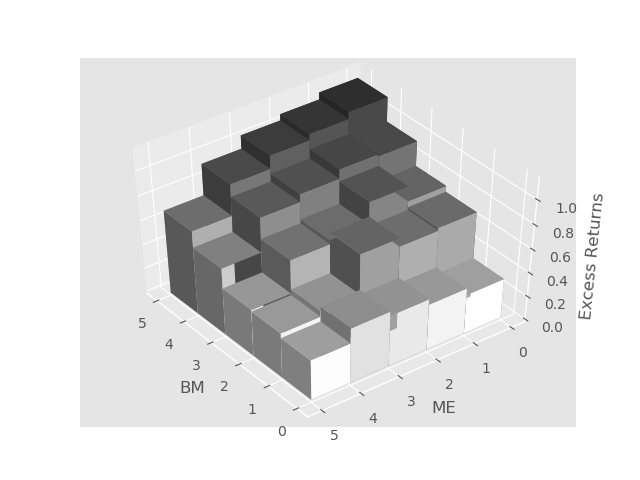

In [29]:
%matplotlib notebook
style.use('ggplot')

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

xx, yy = np.meshgrid(np.arange(5), np.arange(5))
BM, ME = xx.ravel(), yy.ravel()

dx = np.ones(len(BM))
dy = np.ones(len(ME))
dz = mean_exreturns[:-4].values

#Create Colormap
cmap = cm.get_cmap('binary') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz] 


ax1.bar3d(BM, ME, np.zeros(len(BM)), dx, dy, dz, color=rgba)

ax1.view_init(35,150)

ax1.set_xlabel('BM')
ax1.set_ylabel('ME')
ax1.set_zlabel('Excess Returns')

plt.show()

### Excersise 1.2

In [7]:
#Create a empty dictionary to store the results; (:-4) to exclude the FF Factors
results_dict = dict.fromkeys(list(excess_returns_ex1.columns[:-4]))

#Loop over all portfolios and regress:
#Excess_Return(Portfolio) = alpha + beta * Excess_Return(Market) + Std_Error
for portfolio_name in excess_returns_ex1.columns[:-4]:
    
    x = excess_returns_ex1['Mkt-RF']
    y = excess_returns_ex1[portfolio_name]
    
    beta, alpha, r_value, p_value, std_err = stats.linregress(x, y)
    
    results_dict[portfolio_name] = [alpha, beta, r_value, std_err**2]
    
results_ex1 = pd.DataFrame(results_dict, index = ['Alpha', 'Beta', 'R2', 'Std Error'])
results_ex1

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Alpha,-0.293545,0.170184,0.260052,0.494935,0.672094,-0.238948,0.155086,0.400355,0.528070,0.608278,...,-0.068812,-0.062854,0.218328,0.419833,0.472634,-0.097496,-0.046748,0.018162,0.189685,0.316787
Beta,1.423392,1.244513,1.149047,1.067264,1.100706,1.425819,1.228351,1.105138,1.032742,1.122175,...,1.225751,1.125530,1.036729,0.972244,1.081440,1.002311,0.978924,0.860066,0.847501,0.862343
R2,0.828762,0.828235,0.836235,0.818639,0.789311,0.889526,0.892000,0.885613,0.879849,0.849059,...,0.945000,0.950058,0.933757,0.902840,0.872881,0.932051,0.951849,0.900501,0.890095,0.804413
Std Error,0.002497,0.001916,0.001535,0.001515,0.001981,0.001450,0.001047,0.000908,0.000841,0.001318,...,0.000486,0.000369,0.000427,0.000579,0.000988,0.000410,0.000269,0.000466,0.000509,0.001096


In [8]:
#Sorts the values and list them in an output table

def create_output_table(coefficient, data):
    #coefficient has be a string
    
    #Create an empty dictionary to store the results in
    output = dict.fromkeys(['Low ME','ME2','ME3','ME4','High ME'])
    
    output['Low ME']  = data.loc[coefficient][0:5].values
    output['ME2']     = data.loc[coefficient][5:10].values
    output['ME3']     = data.loc[coefficient][10:15].values
    output['ME4']     = data.loc[coefficient][15:20].values
    output['High ME'] = data.loc[coefficient][20:25].values
    
    output_table = pd.DataFrame(output, index = ['Low BM', 'BM2', 'BM3', 'BM4', 'High BM']).T
    output_table.index.name = coefficient
    
    return output_table

In [9]:
#Create and print output table for Alpha
alpha = create_output_table('Alpha', results_ex1)
alpha

,Low BM,BM2,BM3,BM4,High BM
Alpha,,,,,
Low ME,-0.293545,0.170184,0.260052,0.494935,0.672094
ME2,-0.238948,0.155086,0.400355,0.528070,0.608278
ME3,-0.162261,0.256785,0.255127,0.479732,0.583655
ME4,-0.068812,-0.062854,0.218328,0.419833,0.472634
High ME,-0.097496,-0.046748,0.018162,0.189685,0.316787


In [10]:
#Create and print output table for Beta
beta = create_output_table('Beta', results_ex1)
beta

,Low BM,BM2,BM3,BM4,High BM
Beta,,,,,
Low ME,1.423392,1.244513,1.149047,1.067264,1.100706
ME2,1.425819,1.228351,1.105138,1.032742,1.122175
ME3,1.357361,1.156318,1.024763,0.975484,1.067429
ME4,1.225751,1.125530,1.036729,0.972244,1.081440
High ME,1.002311,0.978924,0.860066,0.847501,0.862343


In [11]:
#Create and print output table for Beta
beta = create_output_table('R2', results_ex1)
beta

,Low BM,BM2,BM3,BM4,High BM
R2,,,,,
Low ME,0.828762,0.828235,0.836235,0.818639,0.789311
ME2,0.889526,0.892000,0.885613,0.879849,0.849059
ME3,0.921890,0.925255,0.909140,0.900540,0.855047
ME4,0.945000,0.950058,0.933757,0.902840,0.872881
High ME,0.932051,0.951849,0.900501,0.890095,0.804413


In [12]:
#Create and print output table for Beta
beta = create_output_table('Std Error', results_ex1)
beta

,Low BM,BM2,BM3,BM4,High BM
Std Error,,,,,
Low ME,0.002497,0.001916,0.001535,0.001515,0.001981
ME2,0.001450,0.001047,0.000908,0.000841,0.001318
ME3,0.000880,0.000607,0.000596,0.000599,0.001133
ME4,0.000486,0.000369,0.000427,0.000579,0.000988
High ME,0.000410,0.000269,0.000466,0.000509,0.001096


### Excercise 1.3

In [13]:
#Calculate Expected market return
exp_market_ret = np.mean(excess_returns_ex1['Mkt-RF'])

#Calculate expected portfolio return regarding to CAPM (Expected Market Return * Porfolio Beta)
plot_data = dict.fromkeys(excess_returns_ex1.columns[:-4])

for portfolio_name in excess_returns_ex1.columns[:-4]: 
    
    #Get Portfolio Beta
    port_beta = results_ex1.loc['Beta'][portfolio_name]
    
    #Store the prediction and the actual excess return in the dictionary plot_data
    plot_data[portfolio_name] = [port_beta * exp_market_ret, mean_exreturns[portfolio_name]]

plot_data = pd.DataFrame(plot_data, index = ['CAPM Prediction', 'Actual Excess Return'])

<IPython.core.display.Javascript object>


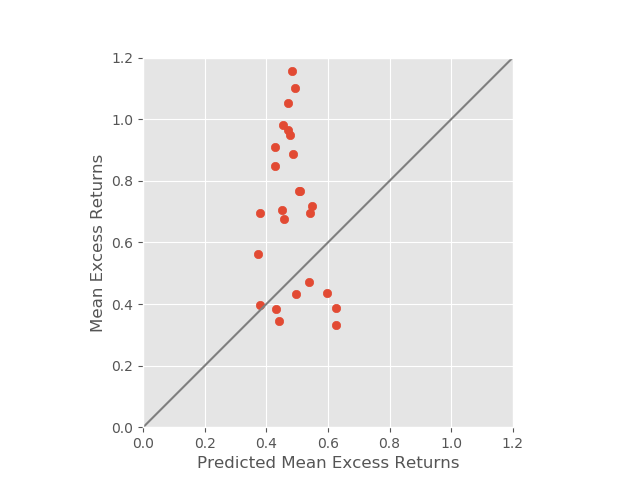

In [28]:
%matplotlib notebook
plt.scatter(plot_data.loc['CAPM Prediction'].values,plot_data.loc['Actual Excess Return'].values)
plt.plot(np.linspace(0,2), np.linspace(0,2), color = 'grey')

axes = plt.gca()
axes.set_xlim([0,1.2])
axes.set_ylim([0,1.2])
plt.gca().set_aspect('equal', adjustable = 'box')

chart_3 = plt.xlabel('Predicted Mean Excess Returns')
chart_3 = plt.ylabel('Mean Excess Returns')

plt.show()

### Excercise 2.1

In [15]:
#Create an empty dict to store the results in
results_ex2 = dict.fromkeys(excess_returns_ex1.columns[:-4])

#Define regression X values
X = np.array([excess_returns_ex1['Mkt-RF'].values] + 
                 [excess_returns_ex1['SMB'].values] + 
                 [excess_returns_ex1['HML'].values]).T 
X = sm.add_constant(X)

#Regress each portfolio on X
for portfolio_name in excess_returns_ex1.columns[:-4]:
    
    Y = np.array(excess_returns_ex1[portfolio_name])

    model = sm.OLS(Y, X)
    results = model.fit()
    
    results_ex2[portfolio_name] = [results.params[0],results.params[1],results.params[2],results.params[3], results.bse[0], results.rsquared]



In [16]:
#Convert the result dict into a dataframe
results_ex2 = pd.DataFrame(results_ex2, index = ['Alpha','Mkt-RF','SMB','HML', 'Std Error Aplha', 'R2'])
results_ex2

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Alpha,-0.379391,-0.114604,-0.089062,0.072007,0.086251,-0.141293,-0.018884,0.122848,0.130196,0.054446,...,0.137414,-0.131784,0.000880,0.063437,-0.003051,0.197878,-0.004568,-0.053771,-0.096162,-0.134584
Mkt-RF,1.039893,0.965751,0.933979,0.890530,0.954170,1.094342,1.017667,0.959494,0.968361,1.068542,...,1.064894,1.071969,1.043765,1.037819,1.144825,0.955553,1.021948,0.968589,1.002070,1.034809
SMB,1.410224,1.293279,1.153828,1.112233,1.205812,1.011670,0.927670,0.830921,0.699198,0.850663,...,0.299380,0.265627,0.238266,0.206378,0.357702,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294
HML,-0.284061,0.095127,0.248883,0.389023,0.641509,-0.478604,0.015927,0.224268,0.472373,0.695112,...,-0.447671,0.037550,0.302256,0.551833,0.711330,-0.449422,-0.012277,0.210888,0.549091,0.792266
Std Error Aplha,0.106342,0.077924,0.062337,0.061107,0.066358,0.080470,0.067520,0.063616,0.060720,0.065605,...,0.072621,0.079831,0.079281,0.078584,0.097666,0.066465,0.070061,0.087112,0.071896,0.112769
R2,0.933327,0.953228,0.964206,0.961792,0.960620,0.956168,0.958191,0.954802,0.953460,0.957150,...,0.945485,0.921030,0.911324,0.907387,0.891926,0.933567,0.919292,0.855326,0.900842,0.807556


In [17]:
alpha2 = create_output_table('Alpha', results_ex2)
alpha2

,Low BM,BM2,BM3,BM4,High BM
Alpha,,,,,
Low ME,-0.379391,-0.114604,-0.089062,0.072007,0.086251
ME2,-0.141293,-0.018884,0.122848,0.130196,0.054446
ME3,-0.026888,0.119910,-0.017685,0.114475,0.063132
ME4,0.137414,-0.131784,0.000880,0.063437,-0.003051
High ME,0.197878,-0.004568,-0.053771,-0.096162,-0.134584


In [18]:
mktrf = create_output_table('Mkt-RF', results_ex2)
mktrf

,Low BM,BM2,BM3,BM4,High BM
Mkt-RF,,,,,
Low ME,1.039893,0.965751,0.933979,0.890530,0.954170
ME2,1.094342,1.017667,0.959494,0.968361,1.068542
ME3,1.101550,1.023491,0.963361,0.972274,1.062852
ME4,1.064894,1.071969,1.043765,1.037819,1.144825
High ME,0.955553,1.021948,0.968589,1.002070,1.034809


In [19]:
smb = create_output_table('SMB', results_ex2)
smb

,Low BM,BM2,BM3,BM4,High BM
SMB,,,,,
Low ME,1.410224,1.293279,1.153828,1.112233,1.205812
ME2,1.011670,0.927670,0.830921,0.699198,0.850663
ME3,0.708367,0.617650,0.538221,0.451434,0.643342
ME4,0.299380,0.265627,0.238266,0.206378,0.357702
High ME,-0.196899,-0.197463,-0.283019,-0.181936,-0.043294


In [20]:
hml = create_output_table('HML', results_ex2)
hml

,Low BM,BM2,BM3,BM4,High BM
HML,,,,,
Low ME,-0.284061,0.095127,0.248883,0.389023,0.641509
ME2,-0.478604,0.015927,0.224268,0.472373,0.695112
ME3,-0.450741,0.046924,0.305873,0.492020,0.701168
ME4,-0.447671,0.037550,0.302256,0.551833,0.711330
High ME,-0.449422,-0.012277,0.210888,0.549091,0.792266


In [21]:
std_alpha = create_output_table('Std Error Aplha', results_ex2)
std_alpha

,Low BM,BM2,BM3,BM4,High BM
Std Error Aplha,,,,,
Low ME,0.106342,0.077924,0.062337,0.061107,0.066358
ME2,0.080470,0.067520,0.063616,0.060720,0.065605
ME3,0.072989,0.070753,0.070312,0.064927,0.082198
ME4,0.072621,0.079831,0.079281,0.078584,0.097666
High ME,0.066465,0.070061,0.087112,0.071896,0.112769


In [22]:
r2 = create_output_table('R2', results_ex2)
r2

,Low BM,BM2,BM3,BM4,High BM
R2,,,,,
Low ME,0.933327,0.953228,0.964206,0.961792,0.960620
ME2,0.956168,0.958191,0.954802,0.953460,0.957150
ME3,0.957262,0.944257,0.932328,0.937519,0.924603
ME4,0.945485,0.921030,0.911324,0.907387,0.891926
High ME,0.933567,0.919292,0.855326,0.900842,0.807556


### Excercise 2.2

In [23]:
print(mean_exreturns)

SMALL LoBM    0.332709
ME1 BM2       0.717737
ME1 BM3       0.765602
ME1 BM4       0.964502
SMALL HiBM    1.156374
ME2 BM1       0.388374
ME2 BM2       0.695528
ME2 BM3       0.886586
ME2 BM4       0.982448
ME2 BM5       1.102005
ME3 BM1       0.434941
ME3 BM2       0.765534
ME3 BM3       0.705995
ME3 BM4       0.908919
ME3 BM5       1.053295
ME4 BM1       0.470486
ME4 BM2       0.432348
ME4 BM3       0.674461
ME4 BM4       0.847594
ME4 BM5       0.948439
BIG LoBM      0.343494
ME5 BM2       0.383952
ME5 BM3       0.396569
ME5 BM4       0.562563
BIG HiBM      0.696194
Mkt-RF        0.439973
SMB           0.279059
HML           0.489194
RF            0.529194
dtype: float64


In [24]:
#BM
print(x)

Date
1963-01-01     4.93
1963-02-01    -2.38
1963-03-01     3.08
1963-04-01     4.51
1963-05-01     1.76
1963-06-01    -2.00
1963-07-01    -0.39
1963-08-01     5.07
1963-09-01    -1.57
1963-10-01     2.53
1963-11-01    -0.85
1963-12-01     1.83
1964-01-01     2.24
1964-02-01     1.54
1964-03-01     1.41
1964-04-01     0.10
1964-05-01     1.42
1964-06-01     1.27
1964-07-01     1.74
1964-08-01    -1.44
1964-09-01     2.69
1964-10-01     0.59
1964-11-01     0.00
1964-12-01     0.03
1965-01-01     3.54
1965-02-01     0.44
1965-03-01    -1.34
1965-04-01     3.11
1965-05-01    -0.77
1965-06-01    -5.51
              ...  
1991-07-01     4.24
1991-08-01     2.32
1991-09-01    -1.59
1991-10-01     1.29
1991-11-01    -4.19
1991-12-01    10.84
1992-01-01    -0.59
1992-02-01     1.09
1992-03-01    -2.66
1992-04-01     1.07
1992-05-01     0.30
1992-06-01    -2.34
1992-07-01     3.77
1992-08-01    -2.38
1992-09-01     1.19
1992-10-01     1.02
1992-11-01     4.13
1992-12-01     1.53
1993-01-01     

In [25]:
#ME
print(y)

Date
1963-01-01     5.4031
1963-02-01    -1.3990
1963-03-01     4.8249
1963-04-01     8.1929
1963-05-01     5.5326
1963-06-01    -0.5890
1963-07-01    -1.3726
1963-08-01     6.1324
1963-09-01    -3.7663
1963-10-01     0.1957
1963-11-01     1.0755
1963-12-01     1.8408
1964-01-01     1.3235
1964-02-01     3.4910
1964-03-01    -0.1606
1964-04-01     2.1277
1964-05-01     3.1264
1964-06-01     2.1156
1964-07-01     0.5222
1964-08-01    -3.0171
1964-09-01     6.6384
1964-10-01     3.3839
1964-11-01    -5.1557
1964-12-01    -1.5681
1965-01-01     3.2278
1965-02-01    -1.3988
1965-03-01    -0.0664
1965-04-01     4.0230
1965-05-01    -3.8641
1965-06-01    -5.7788
               ...   
1991-07-01    -1.4397
1991-08-01     1.1174
1991-09-01    -3.4032
1991-10-01     0.8461
1991-11-01    -9.6817
1991-12-01    13.9433
1992-01-01     6.0939
1992-02-01    10.5784
1992-03-01     0.3685
1992-04-01     9.8456
1992-05-01    -0.5441
1992-06-01     2.6485
1992-07-01    -0.6352
1992-08-01    -9.0669
1992-

In [26]:
print(mean_exreturns)

SMALL LoBM    0.332709
ME1 BM2       0.717737
ME1 BM3       0.765602
ME1 BM4       0.964502
SMALL HiBM    1.156374
ME2 BM1       0.388374
ME2 BM2       0.695528
ME2 BM3       0.886586
ME2 BM4       0.982448
ME2 BM5       1.102005
ME3 BM1       0.434941
ME3 BM2       0.765534
ME3 BM3       0.705995
ME3 BM4       0.908919
ME3 BM5       1.053295
ME4 BM1       0.470486
ME4 BM2       0.432348
ME4 BM3       0.674461
ME4 BM4       0.847594
ME4 BM5       0.948439
BIG LoBM      0.343494
ME5 BM2       0.383952
ME5 BM3       0.396569
ME5 BM4       0.562563
BIG HiBM      0.696194
Mkt-RF        0.439973
SMB           0.279059
HML           0.489194
RF            0.529194
dtype: float64
